# Hazard assessment for droughts

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=Hazard_assessment_DROUGHTS_2.ipynb)  [![Droughts](https://img.shields.io/badge/DROUGHTS_GitHub-repository-blue)](https://github.com/CLIMAAX/DROUGHTS/tree/main)


This is the second and simpler drought workflow.  

## Hazard assessment methodology

In this wrokflow we will assess the ddrought hazard data, expressed as Combined Drought Indicator (CDI).

```{admonition} Hazard data
**The Combined Drought Indicator (CDI)** that is implemented in the European Drought Observatory (EDO) is used to identify areas affected by agricultural drought, and areas with the potential to be affected. CDI can be downloaded from the [Copernicus data server](https://edo.jrc.ec.europa.eu/gdo/php/index.php?id=2112) and is derived by combining three drought indicators produced operationally in the EDO framework - namely the 
- **Standardized Precipitation Index (SPI)**,
- **the Soil Moisture Anomaly (SMA)**, and
- **the FAPAR Anomaly** - in such a way that areas are classified according to three primary drought classes:
  1. “Watch” - indicating that precipitation is less than normal;
  2. “Warning” - indicating that soil moisture is in deficit; and
  3. “Alert” - indicating that vegetation shows signs of stress.  
  ##### Two additional classes - namely
  4. “Partial recovery” and
  5. “Recovery” - identify the stages of the vegetation recovery process. 

Standardized Precipitation Index (SPI): The SPI indicator measures precipitation anomalies at a given location, based on a comparison of observed total precipitation amounts for an accumulation period of interest (e.g. 1, 3, 12, 48 months), with the long-term historic rainfall record for that period (McKee et al., 1993; Edwards and McKee, 1997). 

Soil Moisture Anomaly (SMA): The SMA indicator is derived from anomalies of estimated daily soil moisture (or soil water) content - represented as standardized soil moisture index (SMI) - which is produced by the JRC’s LISFLOOD hydrological model, and which has been shown to be effective for drought detection purposes (Laguardia and Niemeyer, 2008).  

FAPAR Anomaly: The FAPAR Anomaly indicator is computed as deviations of the biophysical variable Fraction of Absorbed Photosynthetically Active Radiation (FAPAR), composited for 10- day intervals, from long-term mean values. Satellite-measured FAPAR represents the fraction of incident solar radiation that is absorbed by land vegetation for photosynthesis, and is effective for detecting and assessing drought impacts on vegetation canopies (Gobron et al., 2005). 
```

:::{list-table} Classification scheme
:widths: 15 10 40
:header-rows: 1

*   - LEVEL
    - COLOUR
    - CLASIFICATION CONDITION
*   - Watch
    - yellow
    - SPI-3 <-1 or SPI-1 < -2
*   - Warning
    - orange
    - SMA <-1 and (SPI-3 < -1 or SPI-1 < -2)
*   - Alert
    - red
    - {math}`\Delta`FAPAR < -1 and (SPI-3 < -1 or SPI-1 < -2)
*   - Partial recovery
    - brown
    - ({math}`\Delta`FAPAR < -1 and (SPI-3{sub}`m-1` < -1 or SPI-3 > -1) or\
      ({math}`\Delta`FAPAR < -1 and (SPI-1{sub}`m-1` < -2 or SPI-1 > -2)
*   - Full recovery
    - grey
    - (SPI-3{sub}`m-1` < -1 and SPI-3 > -1) or\
      (SPI-1{sub}`m-1` < -2 or SPI-1 > -2)
:::

## Preparation work
### Load libraries
`````{admonition} Find more info about the libraries used in this workflow here 👆
:class: hint dropdown
In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
- [matplotlib](https://matplotlib.org/) - For plotting as well
`````

In [1]:
import os
import pooch

import numpy as np
import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr

import pyproj

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'drought_workflow' in the same directory where this notebook is saved.

The cell after will create the **data** directory inside the **drought_workflow**.

In [2]:
workflow_folder = 'simple_drought_workflow'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [3]:
data_dir = os.path.join(workflow_folder,'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Download data

In this workflow we will use a mix of data that is available to download from the notebook, but can also be downloaded using the Copernicus Drought Observatory website.

Since there is no API to download this data, to programatically download the data we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library. Pooch can also unzip the data.  

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

### The Combined Drought Indicator (CDI)

This dataset must be manually downloaded from the [Copernicus Drought Observatory data server](https://edo.jrc.ec.europa.eu/gdo/php/index.php?id=2112). Here we will use only data from 2022. However data is available for the period 2012-2024.  
This dataset is available in geotif and netCDF format. Here we will download netCDF.  

To download the data, you can select all years and click **Download**. Save the data in the **data_dir** folder.

In this example, we will use pooch to download the data for 2022.

In [ ]:
url = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/DROUGHTOBS/Drought_Observatories_datasets/EDO_Combined_Drought_Indicator/ver3-0-1/cdinx_m_euu_20220101_20221221_t.nc'
filename = 'cdinx_m_euu_20220101_20221221_t.nc'

pooch.retrieve(
    url=url,
   known_hash='7a40b16e5a0cfd53a22ef092f6a8bb511925972c9aaa9913a563c7e8585492e7',
    path=data_dir,
    fname=filename)

Note that now we have a directory **simple_drought_workflow/data** where all the zip files and unzipped files are (or should be).  
We can list all the files in the **data_dir** using the os library.  

In [5]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

cdinx_m_euu_20220101_20221221_t.nc


## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### The Combined Drought Indicator (CDI)

All the downloaded netcdf files are stored in our **data_dir** folder, with filenames starting with: **cdinx_m_euu_**, followed by the start and end date period, and ending with **_t.nc**.  
First we can explore one of them.

In [6]:
cdi_nc = xr.open_dataset(f"{data_dir}/cdinx_m_euu_20220101_20221221_t.nc")
cdi_nc

<xarray.Dataset>
Dimensions:  (time: 36, lat: 950, lon: 1000)
Coordinates:
  * lat      (lat) int64 5497500 5492500 5487500 ... 762500 757500 752500
  * lon      (lon) int64 2502500 2507500 2512500 ... 7487500 7492500 7497500
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
Data variables:
    cdinx    (time, lat, lon) float32 ...
    3035     float32 ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2023-06-23
    01.title:                   Combined Drought Indicator (CDI), v.3.0.1
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  https://data.jrc.ec.europa.eu/dataset/afa8a5e...
    19.sample_url:              /images/map_examples/dbio_data_previews/cdinx...
    20.metadata_last_updated:   2023-04-05
    21.values_legend:           0: No drought, 1: Watch. Precipitation defici...
    22.version_notes:           Current version: Version 3.0.1 covers data fr...

We can notice that there are 36 time stamps for 12 months in the year 2022.  
This is because this index is caluclated from the satellite data that takes 10 days to collect the information over the globe. Each time step has index calculated over the previous 10 days.

:::{tip} Explore the file content
Fell free to explore the content and structure of the datasets.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics👆 (click)
:class: dropdown
👋 Click on **3035** 📄 _show/hide attributes_ to see the information about projection of this dataset.  
👋 Click on **Attributes** to find the extensive metadata including projection, resolution, extent, links to documentation, data catalogue etc

:::

## Process the data

In this workflow we want to overlay the population and drought data, to have a better understanding where are densely populated area affected by the drought.

:::{hint} Take a closer look at the dimensions and coordinates of our two data objects.
- Notice that population data is xarray data array and CDI is a dataset. The difference is that dataset contains two variables, the **cdinx** which is the data variable, and **3035** which has the informaiton about the projection.
- Notice that population data has **x** and **y** as spatial dimensions, while CDI has **lat** and **lon**
- The projections and resolutions are very different as well, but they are both in meters.
- The CDI data has time dimension
:::

To be able to plot these two datasets together we must have them in the same projection and zoom to the same area.  

For now we select just one time stamp for the CDI data, for start. We can use xarray sel() method to select one time.  
To check which times are available you can ispect the data few cells above, or print it like in the next cell.

In [7]:
cdi_nc.time

<xarray.DataArray 'time' (time: 36)>
array(['2022-01-01T00:00:00.000000000', '2022-01-11T00:00:00.000000000',
       '2022-01-21T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-02-11T00:00:00.000000000', '2022-02-21T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-03-11T00:00:00.000000000',
       '2022-03-21T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-04-11T00:00:00.000000000', '2022-04-21T00:00:00.000000000',
       '2022-05-01T00:00:00.000000000', '2022-05-11T00:00:00.000000000',
       '2022-05-21T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-06-11T00:00:00.000000000', '2022-06-21T00:00:00.000000000',
       '2022-07-01T00:00:00.000000000', '2022-07-11T00:00:00.000000000',
       '2022-07-21T00:00:00.000000000', '2022-08-01T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-21T00:00:00.000000000',
       '2022-09-01T00:00:00.000000000', '2022-09-11T00:00:00.000000000',
       '2022-09-21T00:00:00.000000000', '2022-10-01T00:00:00.000000000',
       '2022-10-11T00:00:00.000000000', '2022-10-21T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-11-11T00:00:00.000000000',
       '2022-11-21T00:00:00.000000000', '2022-12-01T00:00:00.000000000',
       '2022-12-11T00:00:00.000000000', '2022-12-21T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
Attributes:
    standard_name:  time

In [8]:
cdi = cdi_nc.sel(time='2022-08-01T00:00:00.000000000')

### Select the area of interest

First we define the coordinates of the area of interest. Based on these coordinates we will be able to clip the dataset for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results.

In this workflow we will concentrate on the area of Catalonia. It roughly between 0°E and 3.4°E longitude and 40.5°N and 42.9°N latidude.  
However, the CDI dataset has the spatial coordinates in meters, so it is not easy to know the values to which we need to clip the area.

For this we can use the [pyproj](https://pyproj4.github.io/pyproj/stable/index.html) library.  
Here we use the [proj-string](https://proj.org/en/9.3/usage/quickstart.html) of the Lambert Azimuthal Equal Area projection. This information can be found in the attributes of the CDI datatset under '3035' variable.

In [9]:
cdi_nc["3035"].proj4_params

'+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000+y_0=3210000 +ellps=GRS80 +units=m +no_defs'

In [10]:
xmin=0
ymin=40.5
xmax=3.4
ymax=42.9

In [11]:
xyproj = pyproj.Proj('+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs')
latlonproj = pyproj.Proj('epsg:4326')
transformer = pyproj.Transformer.from_proj(latlonproj, xyproj)
(xmin_xyproj,ymin_xyproj) = transformer.transform(ymin, xmin)
(xmax_xyproj,ymax_xyproj) = transformer.transform(ymax, xmax)

Here are our transformed coordinates of the boundary box.

In [12]:
xmin_xyproj,ymin_xyproj

(3472008.40051275, 1989781.4970224823)

In [13]:
xmax_xyproj,ymax_xyproj

(3781134.3733767485, 2222944.719518429)

:::{caution} Attention!
One very sneaky thing to note here is that latitudes (y dimension) in the dataset is **decreasing**.   
This is very important as this means we need to have the minimum and maximum y value in this order when selecting the area.
:::

There are two ways of selecting area. We can use xarray sel() function or rasterio rio.clip_box.  
::::{tab-set}

:::{tab-item} xarray
```
catalonia_cdi = cdi.sel(lat=slice(ymax_xyproj,ymin_xyproj), 
                        lon=slice(xmin_xyproj,xmax_xyproj))
```
:::

:::{tab-item} rasterio
```
catalonia_cdi = cdi.rio.clip_box(
    minx=xmin,
    miny=ymin,
    maxx=xmax,
    maxy=ymax,
   crs="EPSG:3050",
)
```
:::

::::

In [14]:
catalonia_cdi = cdi.sel(lat=slice(ymax_xyproj,ymin_xyproj), 
                        lon=slice(xmin_xyproj,xmax_xyproj))
catalonia_cdi

<xarray.Dataset>
Dimensions:  (lat: 47, lon: 62)
Coordinates:
  * lat      (lat) int64 2222500 2217500 2212500 ... 2002500 1997500 1992500
  * lon      (lon) int64 3472500 3477500 3482500 ... 3767500 3772500 3777500
    time     datetime64[ns] 2022-08-01
Data variables:
    cdinx    (lat, lon) float32 ...
    3035     float32 ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2023-06-23
    01.title:                   Combined Drought Indicator (CDI), v.3.0.1
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  https://data.jrc.ec.europa.eu/dataset/afa8a5e...
    19.sample_url:              /images/map_examples/dbio_data_previews/cdinx...
    20.metadata_last_updated:   2023-04-05
    21.values_legend:           0: No drought, 1: Watch. Precipitation defici...
    22.version_notes:           Current version: Version 3.0.1 covers data fr...

The last thing left to do is reproject the CDI data.  
In order for rioxarray to be able to reproject the data, it needs to know the projection. NetCDF files store the projection information in its variables or attributes, so for rioxarray we need to write it using rio.write_crs().  

`````{admonition} More info about coordinate system and projections in NetCDF data👆 (click)
:class: hint dropdown

Read more about projections and coordinate information in NetCDF data in:
- [CF convention](https://cfconventions.org/cf-conventions/cf-conventions.html#grid-mappings-and-projections) and in 
- [pyproj documentation](https://pyproj4.github.io/pyproj/stable/build_crs_cf.html).

`````

In [15]:
catalonia_cdi.rio.write_crs(3035, inplace=True)
catalonia_cdi_latlon = catalonia_cdi.rio.reproject("EPSG:4326")

## Plot it together

### Basic plot
With a little bit of code, we can simply plot the dataset.

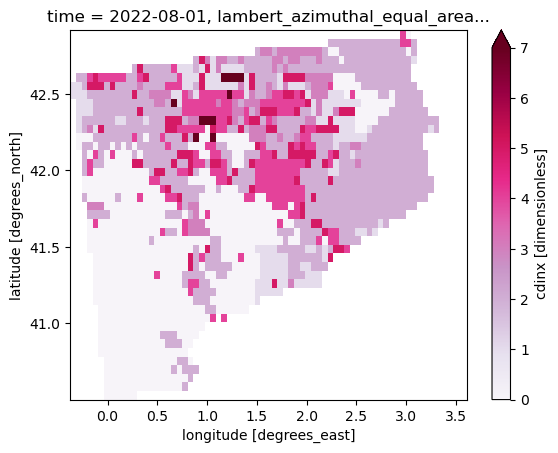

In [16]:
catalonia_cdi_latlon.cdinx.plot(cmap=plt.cm.PuRd, extend='max')

This plot doesn't really help us assessing drought levels and doing climate risk assessemnt, so we can try to make a few changes to the map.

### Custom plot

Text(2.1686, 41.3874, '+ Barcelona')

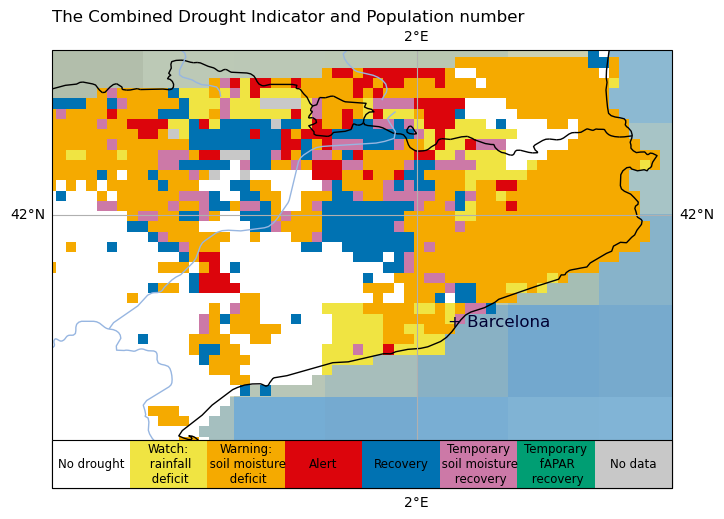

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi_latlon.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

# Customize gridlines
gridlines = c.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

plt.title('The Combined Drought Indicator and Population number', loc = "left")

# CDI colorbar
cax_c = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0,
                    ax.get_position().width,
                    0.08])
cbar_c = plt.colorbar(c, orientation="horizontal", cax=cax_c)
cbar_c.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['No drought', 'Watch:\n rainfall\n deficit', 'Warning:\n soil moisture\n deficit', 'Alert','Recovery','Temporary\n soil moisture\n recovery','Temporary\n fAPAR\n recovery','No data']):
    cbar_c.ax.text(j, .5, lab, ha='center', va='center', size=8.5)

#text
barcelona_lon, barcelona_lat = 2.1686, 41.3874
text_kwargs = dict(fontsize=12, color='#000032', transform=ccrs.PlateCarree())
c.axes.text(barcelona_lon, barcelona_lat, '+ Barcelona', horizontalalignment='left', **text_kwargs)

## Conclusions

In this workflow, we have seen how to explore, process and visualise the drought data.

## Contributors
Milana Vuckovic, ECMWF  
Maurizio Mazzoleni, Vrije Universiteit Amsterdam

## Appendix I - Customised plot explained step by step

We will: 
- Add coastlines, rivers and country borders using cartopy
- Set distinct colour levels for CDI
- Remove the default colorbar and labels
- Add custom colorbars and title
- Add custom gridlines
- And finally add a label for Barcelona

### Background 
First we make a basic plot and set geographical extent to our domain. This way we can zoom in without having to manipulate the data.  
We can also add some (low resolution) background.

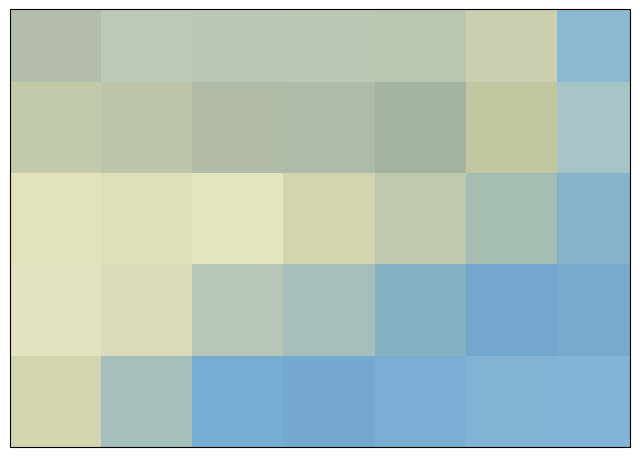

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add background image with orography
ax.stock_img()

### Adding the data
Next we add the data.  
Here we customize the levels on both plots. We will also remove the default colorbar and labels, so in the next step we can add our own.

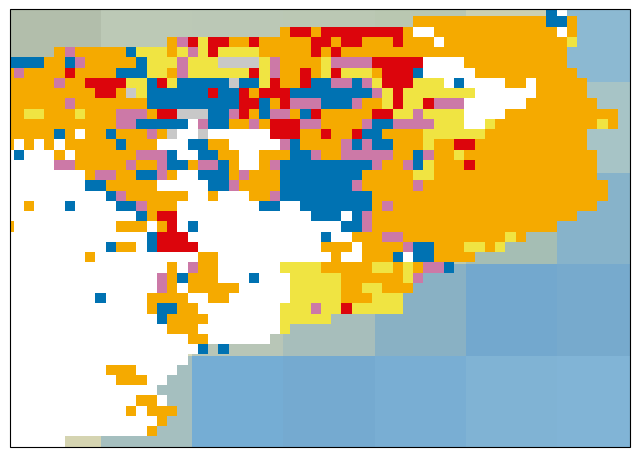

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()
#----------- New code to plot the data -----------#
# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi_latlon.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

### Adding the geographical features
Next we add the gridlines, coastlines, rivers and country borders.

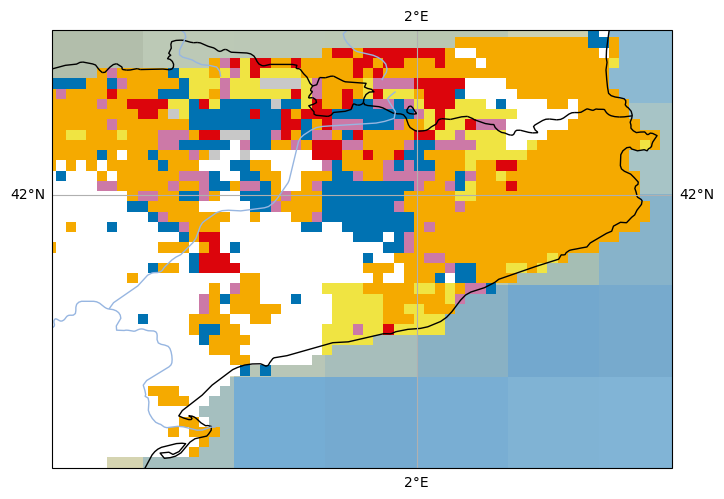

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi_latlon.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

#----------- New code to customize gridlines -----------#
gridlines = c.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

### Adding the title
Then we add the title. 

Text(0.0, 1.0, 'The Combined Drought Indicator and Population number')

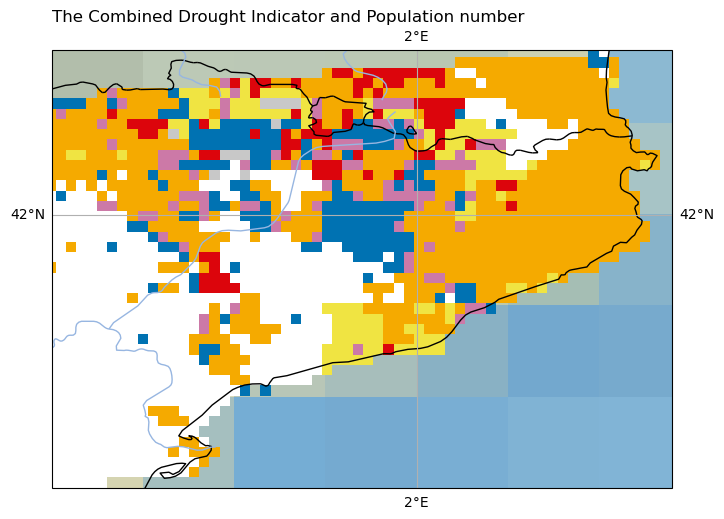

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi_latlon.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

# Customize gridlines
gridlines = c.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

#----------- New code to add the title -----------#

plt.title('The Combined Drought Indicator and Population number', loc = "left")

### Adding the colorbar
It is a little bit tricky to add colorbars to where we want them.  
**cax_p** and **cax_c** variable define the positions and size of the colorbars. They get the default position and size of the colorbars and make them half as long and next to each other.  
In the end we also make the tick labels smaller.

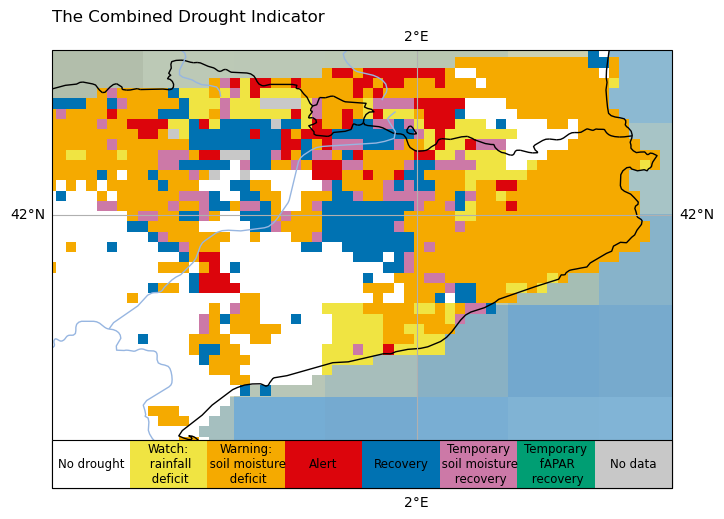

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi_latlon.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

# Customize gridlines
gridlines = c.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

plt.title('The Combined Drought Indicator', loc = "left")

#----------- New code to add the horizontal colorbar -----------#
cax_c = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0,
                    ax.get_position().width,
                    0.08])
cbar_c = plt.colorbar(c, orientation="horizontal", cax=cax_c)
cbar_c.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['No drought', 'Watch:\n rainfall\n deficit', 'Warning:\n soil moisture\n deficit', 'Alert','Recovery','Temporary\n soil moisture\n recovery','Temporary\n fAPAR\n recovery','No data']):
    cbar_c.ax.text(j, .5, lab, ha='center', va='center', size=8.5)

### Adding the custom text label

Finally we can add the label for Barcelona.

Text(2.1686, 41.3874, '+ Barcelona')

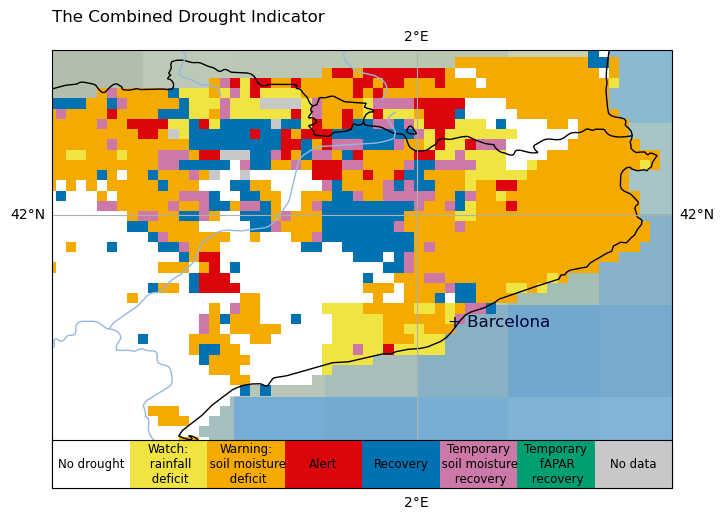

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi_latlon.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

# Customize gridlines
gridlines = c.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

plt.title('The Combined Drought Indicator', loc = "left")

# CDI colorbar
cax_c = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0,
                    ax.get_position().width,
                    0.08])
cbar_c = plt.colorbar(c, orientation="horizontal", cax=cax_c)
cbar_c.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['No drought', 'Watch:\n rainfall\n deficit', 'Warning:\n soil moisture\n deficit', 'Alert','Recovery','Temporary\n soil moisture\n recovery','Temporary\n fAPAR\n recovery','No data']):
    cbar_c.ax.text(j, .5, lab, ha='center', va='center', size=8.5)

#----------- New code to add the text annotation -----------#

barcelona_lon, barcelona_lat = 2.1686, 41.3874
text_kwargs = dict(fontsize=12, color='#000032', transform=ccrs.PlateCarree())
c.axes.text(barcelona_lon, barcelona_lat, '+ Barcelona', horizontalalignment='left', **text_kwargs)